In [ ]:
!sudo rm -rf /content/sample_data

In [ ]:
!curl -L -o /content/archive.zip https://www.kaggle.com/api/v1/datasets/download/rupakroy/urban-sound-8k
!unzip /content/archive.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/UrbanSound8K/UrbanSound8K/audio/fold4/154758-5-0-10.wav  
  inflating: /content/UrbanSound8K/UrbanSound8K/audio/fold4/154758-5-0-11.wav  
  inflating: /content/UrbanSound8K/UrbanSound8K/audio/fold4/154758-5-0-12.wav  
  inflating: /content/UrbanSound8K/UrbanSound8K/audio/fold4/154758-5-0-13.wav  
  inflating: /content/UrbanSound8K/UrbanSound8K/audio/fold4/154758-5-0-14.wav  
  inflating: /content/UrbanSound8K/UrbanSound8K/audio/fold4/154758-5-0-15.wav  
  inflating: /content/UrbanSound8K/UrbanSound8K/audio/fold4/154758-5-0-16.wav  
  inflating: /content/UrbanSound8K/UrbanSound8K/audio/fold4/154758-5-0-17.wav  
  inflating: /content/UrbanSound8K/UrbanSound8K/audio/fold4/154758-5-0-18.wav  
  inflating: /content/UrbanSound8K/UrbanSound8K/audio/fold4/154758-5-0-19.wav  
  inflating: /content/UrbanSound8K/UrbanSound8K/audio/fold4/154758-5-0-2.wav  
  inflating: /content/UrbanSound8K/UrbanSound8K/audio/fold4/154758-5-0

In [ ]:
!sudo rm -rf /content/archive.zip
!sudo rm -rf /content/UrbanSound8K.csv
!sudo rm -rf /content/UrbanSound8K_README.txt

In [ ]:
import pandas as pd

# Load the metadata CSV
csv_file_path = '/content/UrbanSound8K/UrbanSound8K/metadata/UrbanSound8K.csv'  # Replace with the path to UrbanSound8K.csv
metadata = pd.read_csv(csv_file_path)

# Find unique class names and their corresponding numbers
unique_classes = metadata[['classID', 'class']].drop_duplicates().sort_values(by='classID').reset_index(drop=True)

# Display the unique classes and their IDs
print("Unique classes and their corresponding class IDs:")
print(unique_classes)


Unique classes and their corresponding class IDs:
   classID             class
0        0   air_conditioner
1        1          car_horn
2        2  children_playing
3        3          dog_bark
4        4          drilling
5        5     engine_idling
6        6          gun_shot
7        7        jackhammer
8        8             siren
9        9      street_music


In [ ]:
classes_to_keep = [0,2,3,4,6,8,9]

In [ ]:
import pandas as pd
import numpy as np
import librosa
import os

def load_filtered_metadata(csv_file_path, classes_to_keep):
    # Load the metadata CSV file
    metadata = pd.read_csv(csv_file_path)
    # Filter the metadata to keep only the specified classes
    filtered_metadata = metadata[metadata['classID'].isin(classes_to_keep)]
    return filtered_metadata


In [ ]:
!pip install librosa

In [ ]:
def convert_to_mfcc_with_filtered_labels(audio_dir, metadata, max_pad_len=200):
    # Initialize dataset list
    dataset = []

    for index, row in metadata.iterrows():
        # Build file path
        file_name = row['slice_file_name']
        fold = row['fold']
        label = row['classID']
        file_path = os.path.join(audio_dir, f'fold{fold}', file_name)

        # Load the audio file
        try:
            audio, sr = librosa.load(file_path)

            # Convert to MFCC
            mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)

            # Pad or truncate MFCCs to ensure uniform shape
            if mfccs.shape[1] < max_pad_len:
                pad_width = max_pad_len - mfccs.shape[1]
                mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
            else:
                mfccs = mfccs[:, :max_pad_len]

            # Append (features, label) as a tuple to the dataset list
            dataset.append((mfccs, label))

        except Exception as e:
            print(f"Error processing file {file_path}: {e}")
            continue

    # Convert dataset list to a NumPy array
    return np.array(dataset, dtype=object)


# Paths
audio_dir = '/content/UrbanSound8K/UrbanSound8K/audio'  # Replace with the path to the UrbanSound8K audio directory

# Load filtered metadata and create the dataset
filtered_metadata = load_filtered_metadata(csv_file_path, classes_to_keep)
dataset = convert_to_mfcc_with_filtered_labels(audio_dir, filtered_metadata)

# Check dataset shape and structure
print("Filtered dataset shape:", dataset.shape)
print("First element (MFCCs, Label):", dataset[0])


Filtered dataset shape: (6303, 2)
First element (MFCCs, Label): [array([[-332.03882  , -169.58778  ,  -90.246826 , ...,    0.       ,
            0.       ,    0.       ],
        [ 119.39658  ,   83.29507  ,   61.688717 , ...,    0.       ,
            0.       ,    0.       ],
        [-102.87578  , -120.09383  , -129.49959  , ...,    0.       ,
            0.       ,    0.       ],
        ...,
        [  12.779535 ,    3.54832  ,   -6.067366 , ...,    0.       ,
            0.       ,    0.       ],
        [  -3.7113376,  -11.908622 ,   -5.738103 , ...,    0.       ,
            0.       ,    0.       ],
        [ -21.403107 ,  -27.239983 ,  -21.733372 , ...,    0.       ,
            0.       ,    0.       ]], dtype=float32)                 3]


In [ ]:
# Convert dataset to separate features and labels arrays
features = np.array([sample[0] for sample in dataset], dtype=np.float32)  # Shape: (6732, n_mfcc, max_pad_len)
labels = np.array([sample[1] for sample in dataset], dtype=int)           # Shape: (6732,)

print("Features shape:", features.shape)
print("Labels shape:", labels.shape)


Features shape: (6303, 13, 200)
Labels shape: (6303,)


In [ ]:
# Counting unique labels and their occurrences
unique_labels, counts = np.unique(labels, return_counts=True)

# Print the counts of each label
for label, count in zip(unique_labels, counts):
    print(f"Label: {label}, Count: {count}")

Label: 0, Count: 1000
Label: 2, Count: 1000
Label: 3, Count: 1000
Label: 4, Count: 1000
Label: 6, Count: 374
Label: 8, Count: 929
Label: 9, Count: 1000


In [ ]:
!curl -L -o /content/gunshot.zip https://www.kaggle.com/api/v1/datasets/download/emrahaydemr/gunshot-audio-dataset
!unzip /content/gunshot.zip -d /content/Gunshot
!sudo rm -rf /content/gunshot.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  380M  100  380M    0     0   122M      0  0:00:03  0:00:03 --:--:--  160M
Archive:  /content/gunshot.zip
  inflating: /content/Gunshot/AK-12/3 (1).wav  
  inflating: /content/Gunshot/AK-12/3 (10).wav  
  inflating: /content/Gunshot/AK-12/3 (11).wav  
  inflating: /content/Gunshot/AK-12/3 (12).wav  
  inflating: /content/Gunshot/AK-12/3 (13).wav  
  inflating: /content/Gunshot/AK-12/3 (14).wav  
  inflating: /content/Gunshot/AK-12/3 (15).wav  
  inflating: /content/Gunshot/AK-12/3 (16).wav  
  inflating: /content/Gunshot/AK-12/3 (17).wav  
  inflating: /content/Gunshot/AK-12/3 (18).wav  
  inflating: /content/Gunshot/AK-12/3 (19).wav  
  inflating: /content/Gunshot/AK-12/3 (2).wav  
  inflating: /content/Gunshot/AK-12/3 (20).wav  
  inflating: /cont

In [ ]:
import os
import librosa
import numpy as np

# Path to the main folder containing gunshot subfolders
gunshot_main_folder = '/content/Gunshot'  # Replace with actual path
gunshot_label_id = 6  # Label ID for gunshot as per UrbanSound8K's classID

# Parameters for MFCC extraction
n_mfcc = 13
max_pad_len = 200

# Ensure dataset is a list initially
dataset = dataset.tolist() if isinstance(dataset, np.ndarray) else dataset

# Function to process and add gunshot files from multiple subfolders
def add_combined_gunshots_to_dataset(main_folder, label_id, dataset):
    for subfolder in os.listdir(main_folder):
        subfolder_path = os.path.join(main_folder, subfolder)

        # Skip if it's not a directory
        if not os.path.isdir(subfolder_path):
            continue

        # Process each file in the subfolder
        for file_name in os.listdir(subfolder_path):
            file_path = os.path.join(subfolder_path, file_name)

            # Load audio and compute MFCCs
            audio, sr = librosa.load(file_path)
            mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)

            # Pad or truncate MFCCs to ensure uniform shape
            if mfccs.shape[1] < max_pad_len:
                pad_width = max_pad_len - mfccs.shape[1]
                mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
            else:
                mfccs = mfccs[:, :max_pad_len]

            # Append the MFCC and label tuple to the dataset list
            dataset.append((mfccs, label_id))

# Call the function to add gunshot data from all subfolders
add_combined_gunshots_to_dataset(gunshot_main_folder, gunshot_label_id, dataset)

# Convert dataset to NumPy array if needed
dataset = np.array(dataset, dtype=object)  # dtype=object due to mixed types (MFCC array and label)

print("Updated dataset shape:", dataset.shape)


Updated dataset shape: (7154, 2)


In [ ]:
# Convert dataset to separate features and labels arrays
features = np.array([sample[0] for sample in dataset], dtype=np.float32)  # Shape: (6732, n_mfcc, max_pad_len)
labels = np.array([sample[1] for sample in dataset], dtype=int)           # Shape: (6732,)

print("Features shape:", features.shape)
print("Labels shape:", labels.shape)


Features shape: (7154, 13, 200)
Labels shape: (7154,)


In [ ]:
# Counting unique labels and their occurrences
unique_labels, counts = np.unique(labels, return_counts=True)

# Print the counts of each label
for label, count in zip(unique_labels, counts):
    print(f"Label: {label}, Count: {count}")

Label: 0, Count: 1000
Label: 2, Count: 1000
Label: 3, Count: 1000
Label: 4, Count: 1000
Label: 6, Count: 1225
Label: 8, Count: 929
Label: 9, Count: 1000


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

# Define the ratios for train, validation, and test splits
train_ratio = 0.7
valid_ratio = 0.15
test_ratio = 0.15

# Split dataset into train and temp
X_train, X_temp, y_train, y_temp = train_test_split(
    features,
    labels,
    test_size=(1 - train_ratio),
    stratify=labels,
    random_state=42
)

# Then split temp into validation and test
test_size_ratio = test_ratio / (test_ratio + valid_ratio)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=test_size_ratio,
    stratify=y_temp,
    random_state=42
)

# Check the shapes of each set
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_valid.shape, y_valid.shape)
print("Test set shape:", X_test.shape, y_test.shape)

# Check label distribution in each set
def check_class_distribution(labels, name):
    unique_labels, counts = np.unique(labels, return_counts=True)
    print(f"\n{name} Set Class Distribution:")
    for label, count in zip(unique_labels, counts):
        print(f"Label: {label}, Count: {count}")

check_class_distribution(y_train, "Training")
check_class_distribution(y_valid, "Validation")
check_class_distribution(y_test, "Test")

Training set shape: (5007, 13, 200) (5007,)
Validation set shape: (1073, 13, 200) (1073,)
Test set shape: (1074, 13, 200) (1074,)

Training Set Class Distribution:
Label: 0, Count: 700
Label: 2, Count: 700
Label: 3, Count: 700
Label: 4, Count: 700
Label: 6, Count: 857
Label: 8, Count: 650
Label: 9, Count: 700

Validation Set Class Distribution:
Label: 0, Count: 150
Label: 2, Count: 150
Label: 3, Count: 150
Label: 4, Count: 150
Label: 6, Count: 184
Label: 8, Count: 139
Label: 9, Count: 150

Test Set Class Distribution:
Label: 0, Count: 150
Label: 2, Count: 150
Label: 3, Count: 150
Label: 4, Count: 150
Label: 6, Count: 184
Label: 8, Count: 140
Label: 9, Count: 150


In [ ]:
!pip install seaborn tqdm

In [ ]:
# HIDDEN_SIZE = 128    # Try 64, 128, 256
# NUM_LAYERS = 2       # Try 1, 2, 3
# DROPOUT = 0.3        # Try 0.2, 0.3, 0.4
# BATCH_SIZE = 32      # Try 16, 32, 64
# LEARNING_RATE = 0.001  # Try 0.01, 0.001, 0.0001

Using device: cuda

Epoch 1/100


Training: 100%|██████████| 157/157 [00:02<00:00, 65.06it/s, loss=1.5900, acc=35.61%]


Train Loss: 1.5900, Train Acc: 0.3561
Valid Loss: 1.3527, Valid Acc: 0.4352

Epoch 2/100


Training: 100%|██████████| 157/157 [00:02<00:00, 57.34it/s, loss=1.2545, acc=52.93%]


Train Loss: 1.2545, Train Acc: 0.5293
Valid Loss: 1.3549, Valid Acc: 0.5144

Epoch 3/100


Training: 100%|██████████| 157/157 [00:02<00:00, 65.99it/s, loss=1.0557, acc=64.33%]


Train Loss: 1.0557, Train Acc: 0.6433
Valid Loss: 0.9434, Valid Acc: 0.6859

Epoch 4/100


Training: 100%|██████████| 157/157 [00:02<00:00, 68.33it/s, loss=0.9290, acc=69.44%]


Train Loss: 0.9290, Train Acc: 0.6944
Valid Loss: 0.8978, Valid Acc: 0.7139

Epoch 5/100


Training: 100%|██████████| 157/157 [00:02<00:00, 69.49it/s, loss=0.8726, acc=71.56%]


Train Loss: 0.8726, Train Acc: 0.7156
Valid Loss: 0.8721, Valid Acc: 0.7102

Epoch 6/100


Training: 100%|██████████| 157/157 [00:02<00:00, 68.42it/s, loss=0.8080, acc=73.32%]


Train Loss: 0.8080, Train Acc: 0.7332
Valid Loss: 0.7482, Valid Acc: 0.7465

Epoch 7/100


Training: 100%|██████████| 157/157 [00:02<00:00, 68.75it/s, loss=0.7806, acc=74.34%]


Train Loss: 0.7806, Train Acc: 0.7434
Valid Loss: 0.8046, Valid Acc: 0.7195

Epoch 8/100


Training: 100%|██████████| 157/157 [00:02<00:00, 64.77it/s, loss=0.7556, acc=75.19%]


Train Loss: 0.7556, Train Acc: 0.7519
Valid Loss: 0.7217, Valid Acc: 0.7465

Epoch 9/100


Training: 100%|██████████| 157/157 [00:02<00:00, 67.34it/s, loss=0.6933, acc=77.21%]


Train Loss: 0.6933, Train Acc: 0.7721
Valid Loss: 0.6893, Valid Acc: 0.7773

Epoch 10/100


Training: 100%|██████████| 157/157 [00:02<00:00, 68.07it/s, loss=0.6592, acc=78.25%]


Train Loss: 0.6592, Train Acc: 0.7825
Valid Loss: 0.7264, Valid Acc: 0.7670

Epoch 11/100


Training: 100%|██████████| 157/157 [00:02<00:00, 68.93it/s, loss=0.6379, acc=78.49%]


Train Loss: 0.6379, Train Acc: 0.7849
Valid Loss: 0.6432, Valid Acc: 0.7866

Epoch 12/100


Training: 100%|██████████| 157/157 [00:02<00:00, 68.82it/s, loss=0.6086, acc=80.25%]


Train Loss: 0.6086, Train Acc: 0.8025
Valid Loss: 0.6858, Valid Acc: 0.7763

Epoch 13/100


Training: 100%|██████████| 157/157 [00:02<00:00, 65.82it/s, loss=0.5897, acc=81.25%]


Train Loss: 0.5897, Train Acc: 0.8125
Valid Loss: 0.6891, Valid Acc: 0.7661

Epoch 14/100


Training: 100%|██████████| 157/157 [00:02<00:00, 64.67it/s, loss=0.5781, acc=81.05%]


Train Loss: 0.5781, Train Acc: 0.8105
Valid Loss: 0.5874, Valid Acc: 0.8099

Epoch 15/100


Training: 100%|██████████| 157/157 [00:02<00:00, 65.14it/s, loss=0.5568, acc=82.16%]


Train Loss: 0.5568, Train Acc: 0.8216
Valid Loss: 0.5919, Valid Acc: 0.8192

Epoch 16/100


Training: 100%|██████████| 157/157 [00:02<00:00, 68.57it/s, loss=0.5462, acc=82.46%]


Train Loss: 0.5462, Train Acc: 0.8246
Valid Loss: 0.6514, Valid Acc: 0.7959

Epoch 17/100


Training: 100%|██████████| 157/157 [00:02<00:00, 69.41it/s, loss=0.5029, acc=83.78%]


Train Loss: 0.5029, Train Acc: 0.8378
Valid Loss: 0.5505, Valid Acc: 0.8220

Epoch 18/100


Training: 100%|██████████| 157/157 [00:02<00:00, 67.99it/s, loss=0.4910, acc=84.10%]


Train Loss: 0.4910, Train Acc: 0.8410
Valid Loss: 0.6164, Valid Acc: 0.8155

Epoch 19/100


Training: 100%|██████████| 157/157 [00:02<00:00, 65.08it/s, loss=0.4970, acc=84.12%]


Train Loss: 0.4970, Train Acc: 0.8412
Valid Loss: 0.6319, Valid Acc: 0.8080

Epoch 20/100


Training: 100%|██████████| 157/157 [00:02<00:00, 69.27it/s, loss=0.4735, acc=84.78%]


Train Loss: 0.4735, Train Acc: 0.8478
Valid Loss: 0.5876, Valid Acc: 0.8220

Epoch 21/100


Training: 100%|██████████| 157/157 [00:02<00:00, 69.93it/s, loss=0.4746, acc=84.88%]


Train Loss: 0.4746, Train Acc: 0.8488
Valid Loss: 0.5624, Valid Acc: 0.8360

Epoch 22/100


Training: 100%|██████████| 157/157 [00:02<00:00, 69.56it/s, loss=0.4545, acc=85.42%]


Train Loss: 0.4545, Train Acc: 0.8542
Valid Loss: 0.5879, Valid Acc: 0.8201

Epoch 23/100


Training: 100%|██████████| 157/157 [00:02<00:00, 69.65it/s, loss=0.4348, acc=86.82%]


Train Loss: 0.4348, Train Acc: 0.8682
Valid Loss: 0.5741, Valid Acc: 0.8239

Epoch 24/100


Training: 100%|██████████| 157/157 [00:02<00:00, 67.58it/s, loss=0.3832, acc=88.08%]


Train Loss: 0.3832, Train Acc: 0.8808
Valid Loss: 0.5013, Valid Acc: 0.8462

Epoch 25/100


Training: 100%|██████████| 157/157 [00:02<00:00, 68.40it/s, loss=0.3356, acc=89.73%]


Train Loss: 0.3356, Train Acc: 0.8973
Valid Loss: 0.4841, Valid Acc: 0.8537

Epoch 26/100


Training: 100%|██████████| 157/157 [00:02<00:00, 69.62it/s, loss=0.3241, acc=90.05%]


Train Loss: 0.3241, Train Acc: 0.9005
Valid Loss: 0.4913, Valid Acc: 0.8537

Epoch 27/100


Training: 100%|██████████| 157/157 [00:02<00:00, 70.12it/s, loss=0.3075, acc=90.39%]


Train Loss: 0.3075, Train Acc: 0.9039
Valid Loss: 0.5018, Valid Acc: 0.8555

Epoch 28/100


Training: 100%|██████████| 157/157 [00:02<00:00, 69.06it/s, loss=0.3120, acc=90.49%]


Train Loss: 0.3120, Train Acc: 0.9049
Valid Loss: 0.5006, Valid Acc: 0.8574

Epoch 29/100


Training: 100%|██████████| 157/157 [00:02<00:00, 68.75it/s, loss=0.2999, acc=90.79%]


Train Loss: 0.2999, Train Acc: 0.9079
Valid Loss: 0.5186, Valid Acc: 0.8574

Epoch 30/100


Training: 100%|██████████| 157/157 [00:02<00:00, 67.51it/s, loss=0.2945, acc=91.01%]


Train Loss: 0.2945, Train Acc: 0.9101
Valid Loss: 0.5248, Valid Acc: 0.8555

Epoch 31/100


Training: 100%|██████████| 157/157 [00:02<00:00, 70.52it/s, loss=0.2912, acc=91.13%]


Train Loss: 0.2912, Train Acc: 0.9113
Valid Loss: 0.5486, Valid Acc: 0.8537

Epoch 32/100


Training: 100%|██████████| 157/157 [00:02<00:00, 69.95it/s, loss=0.2798, acc=91.51%]


Train Loss: 0.2798, Train Acc: 0.9151
Valid Loss: 0.5316, Valid Acc: 0.8583

Epoch 33/100


Training: 100%|██████████| 157/157 [00:02<00:00, 69.52it/s, loss=0.2780, acc=91.53%]


Train Loss: 0.2780, Train Acc: 0.9153
Valid Loss: 0.5375, Valid Acc: 0.8593

Epoch 34/100


Training: 100%|██████████| 157/157 [00:02<00:00, 70.11it/s, loss=0.2733, acc=91.53%]


Train Loss: 0.2733, Train Acc: 0.9153
Valid Loss: 0.5346, Valid Acc: 0.8583

Epoch 35/100


Training: 100%|██████████| 157/157 [00:02<00:00, 67.12it/s, loss=0.2821, acc=91.51%]


Train Loss: 0.2821, Train Acc: 0.9151
Valid Loss: 0.5287, Valid Acc: 0.8611

Epoch 36/100


Training: 100%|██████████| 157/157 [00:02<00:00, 68.55it/s, loss=0.2671, acc=91.77%]


Train Loss: 0.2671, Train Acc: 0.9177
Valid Loss: 0.5383, Valid Acc: 0.8611

Epoch 37/100


Training: 100%|██████████| 157/157 [00:02<00:00, 69.49it/s, loss=0.2708, acc=91.77%]


Train Loss: 0.2708, Train Acc: 0.9177
Valid Loss: 0.5413, Valid Acc: 0.8602

Epoch 38/100


Training: 100%|██████████| 157/157 [00:02<00:00, 69.62it/s, loss=0.2728, acc=91.77%]


Train Loss: 0.2728, Train Acc: 0.9177
Valid Loss: 0.5360, Valid Acc: 0.8574

Epoch 39/100


Training: 100%|██████████| 157/157 [00:02<00:00, 69.34it/s, loss=0.2742, acc=91.77%]


Train Loss: 0.2742, Train Acc: 0.9177
Valid Loss: 0.5364, Valid Acc: 0.8583

Epoch 40/100


Training: 100%|██████████| 157/157 [00:02<00:00, 68.96it/s, loss=0.2728, acc=91.61%]


Train Loss: 0.2728, Train Acc: 0.9161
Valid Loss: 0.5346, Valid Acc: 0.8611

Epoch 41/100


Training: 100%|██████████| 157/157 [00:02<00:00, 67.29it/s, loss=0.2735, acc=91.51%]


Train Loss: 0.2735, Train Acc: 0.9151
Valid Loss: 0.5440, Valid Acc: 0.8611

Epoch 42/100


Training: 100%|██████████| 157/157 [00:02<00:00, 69.43it/s, loss=0.2768, acc=91.59%]


Train Loss: 0.2768, Train Acc: 0.9159
Valid Loss: 0.5402, Valid Acc: 0.8593

Epoch 43/100


Training: 100%|██████████| 157/157 [00:02<00:00, 69.33it/s, loss=0.2766, acc=91.59%]


Train Loss: 0.2766, Train Acc: 0.9159
Valid Loss: 0.5420, Valid Acc: 0.8621

Epoch 44/100


Training: 100%|██████████| 157/157 [00:02<00:00, 69.49it/s, loss=0.2701, acc=91.67%]


Train Loss: 0.2701, Train Acc: 0.9167
Valid Loss: 0.5437, Valid Acc: 0.8602

Epoch 45/100


Training: 100%|██████████| 157/157 [00:02<00:00, 69.14it/s, loss=0.2713, acc=91.73%]


Train Loss: 0.2713, Train Acc: 0.9173
Valid Loss: 0.5392, Valid Acc: 0.8593

Epoch 46/100


Training: 100%|██████████| 157/157 [00:02<00:00, 68.35it/s, loss=0.2680, acc=91.77%]


Train Loss: 0.2680, Train Acc: 0.9177
Valid Loss: 0.5460, Valid Acc: 0.8602

Epoch 47/100


Training: 100%|██████████| 157/157 [00:02<00:00, 68.79it/s, loss=0.2689, acc=91.59%]


Train Loss: 0.2689, Train Acc: 0.9159
Valid Loss: 0.5436, Valid Acc: 0.8611

Epoch 48/100


Training: 100%|██████████| 157/157 [00:02<00:00, 69.46it/s, loss=0.2684, acc=91.77%]


Train Loss: 0.2684, Train Acc: 0.9177
Valid Loss: 0.5395, Valid Acc: 0.8593

Epoch 49/100


Training: 100%|██████████| 157/157 [00:02<00:00, 69.08it/s, loss=0.2698, acc=91.71%]


Train Loss: 0.2698, Train Acc: 0.9171
Valid Loss: 0.5464, Valid Acc: 0.8593

Epoch 50/100


Training: 100%|██████████| 157/157 [00:02<00:00, 69.08it/s, loss=0.2695, acc=91.67%]


Train Loss: 0.2695, Train Acc: 0.9167
Valid Loss: 0.5429, Valid Acc: 0.8611

Epoch 51/100


Training: 100%|██████████| 157/157 [00:02<00:00, 69.00it/s, loss=0.2662, acc=91.77%]


Train Loss: 0.2662, Train Acc: 0.9177
Valid Loss: 0.5415, Valid Acc: 0.8621

Epoch 52/100


Training: 100%|██████████| 157/157 [00:02<00:00, 67.38it/s, loss=0.2753, acc=91.51%]


Train Loss: 0.2753, Train Acc: 0.9151
Valid Loss: 0.5396, Valid Acc: 0.8583

Epoch 53/100


Training: 100%|██████████| 157/157 [00:02<00:00, 70.07it/s, loss=0.2714, acc=91.73%]


Train Loss: 0.2714, Train Acc: 0.9173
Valid Loss: 0.5421, Valid Acc: 0.8593

Epoch 54/100


Training: 100%|██████████| 157/157 [00:02<00:00, 69.49it/s, loss=0.2718, acc=91.73%]


Train Loss: 0.2718, Train Acc: 0.9173
Valid Loss: 0.5435, Valid Acc: 0.8593

Epoch 55/100


Training: 100%|██████████| 157/157 [00:02<00:00, 69.72it/s, loss=0.2703, acc=91.61%]


Train Loss: 0.2703, Train Acc: 0.9161
Valid Loss: 0.5350, Valid Acc: 0.8611

Epoch 56/100


Training: 100%|██████████| 157/157 [00:02<00:00, 69.91it/s, loss=0.2688, acc=91.85%]


Train Loss: 0.2688, Train Acc: 0.9185
Valid Loss: 0.5399, Valid Acc: 0.8593

Epoch 57/100


Training: 100%|██████████| 157/157 [00:02<00:00, 67.48it/s, loss=0.2709, acc=91.75%]


Train Loss: 0.2709, Train Acc: 0.9175
Valid Loss: 0.5433, Valid Acc: 0.8602

Epoch 58/100


Training: 100%|██████████| 157/157 [00:02<00:00, 68.94it/s, loss=0.2704, acc=91.77%]


Train Loss: 0.2704, Train Acc: 0.9177
Valid Loss: 0.5391, Valid Acc: 0.8593

Epoch 59/100


Training: 100%|██████████| 157/157 [00:02<00:00, 69.06it/s, loss=0.2698, acc=91.87%]


Train Loss: 0.2698, Train Acc: 0.9187
Valid Loss: 0.5367, Valid Acc: 0.8583

Epoch 60/100


Training: 100%|██████████| 157/157 [00:02<00:00, 69.50it/s, loss=0.2704, acc=91.65%]


Train Loss: 0.2704, Train Acc: 0.9165
Valid Loss: 0.5448, Valid Acc: 0.8593

Epoch 61/100


Training: 100%|██████████| 157/157 [00:02<00:00, 69.89it/s, loss=0.2720, acc=91.83%]


Train Loss: 0.2720, Train Acc: 0.9183
Valid Loss: 0.5349, Valid Acc: 0.8574

Epoch 62/100


Training: 100%|██████████| 157/157 [00:02<00:00, 68.81it/s, loss=0.2699, acc=91.87%]


Train Loss: 0.2699, Train Acc: 0.9187
Valid Loss: 0.5407, Valid Acc: 0.8602

Epoch 63/100


Training: 100%|██████████| 157/157 [00:02<00:00, 66.97it/s, loss=0.2719, acc=91.73%]


Train Loss: 0.2719, Train Acc: 0.9173
Valid Loss: 0.5441, Valid Acc: 0.8602

Epoch 64/100


Training: 100%|██████████| 157/157 [00:02<00:00, 70.30it/s, loss=0.2651, acc=91.81%]


Train Loss: 0.2651, Train Acc: 0.9181
Valid Loss: 0.5395, Valid Acc: 0.8593

Epoch 65/100


Training: 100%|██████████| 157/157 [00:02<00:00, 68.50it/s, loss=0.2699, acc=91.73%]


Train Loss: 0.2699, Train Acc: 0.9173
Valid Loss: 0.5396, Valid Acc: 0.8593

Epoch 66/100


Training: 100%|██████████| 157/157 [00:02<00:00, 68.99it/s, loss=0.2708, acc=91.67%]


Train Loss: 0.2708, Train Acc: 0.9167
Valid Loss: 0.5410, Valid Acc: 0.8621

Epoch 67/100


Training: 100%|██████████| 157/157 [00:02<00:00, 69.72it/s, loss=0.2731, acc=91.67%]


Train Loss: 0.2731, Train Acc: 0.9167
Valid Loss: 0.5374, Valid Acc: 0.8593

Epoch 68/100


Training: 100%|██████████| 157/157 [00:02<00:00, 67.01it/s, loss=0.2716, acc=91.65%]


Train Loss: 0.2716, Train Acc: 0.9165
Valid Loss: 0.5399, Valid Acc: 0.8593

Epoch 69/100


Training: 100%|██████████| 157/157 [00:02<00:00, 69.13it/s, loss=0.2687, acc=91.67%]


Train Loss: 0.2687, Train Acc: 0.9167
Valid Loss: 0.5405, Valid Acc: 0.8602

Epoch 70/100


Training: 100%|██████████| 157/157 [00:02<00:00, 69.05it/s, loss=0.2756, acc=91.73%]


Train Loss: 0.2756, Train Acc: 0.9173
Valid Loss: 0.5424, Valid Acc: 0.8593

Epoch 71/100


Training: 100%|██████████| 157/157 [00:02<00:00, 69.75it/s, loss=0.2737, acc=91.81%]


Train Loss: 0.2737, Train Acc: 0.9181
Valid Loss: 0.5390, Valid Acc: 0.8611

Epoch 72/100


Training: 100%|██████████| 157/157 [00:02<00:00, 69.40it/s, loss=0.2702, acc=91.77%]


Train Loss: 0.2702, Train Acc: 0.9177
Valid Loss: 0.5422, Valid Acc: 0.8602

Epoch 73/100


Training: 100%|██████████| 157/157 [00:02<00:00, 67.72it/s, loss=0.2751, acc=91.57%]


Train Loss: 0.2751, Train Acc: 0.9157
Valid Loss: 0.5434, Valid Acc: 0.8593

Epoch 74/100


Training: 100%|██████████| 157/157 [00:02<00:00, 67.10it/s, loss=0.2738, acc=91.93%]


Train Loss: 0.2738, Train Acc: 0.9193
Valid Loss: 0.5416, Valid Acc: 0.8611

Epoch 75/100


Training: 100%|██████████| 157/157 [00:02<00:00, 69.45it/s, loss=0.2663, acc=91.77%]


Train Loss: 0.2663, Train Acc: 0.9177
Valid Loss: 0.5340, Valid Acc: 0.8593

Epoch 76/100


Training: 100%|██████████| 157/157 [00:02<00:00, 69.24it/s, loss=0.2732, acc=91.61%]


Train Loss: 0.2732, Train Acc: 0.9161
Valid Loss: 0.5433, Valid Acc: 0.8611

Epoch 77/100


Training: 100%|██████████| 157/157 [00:02<00:00, 69.51it/s, loss=0.2784, acc=91.81%]


Train Loss: 0.2784, Train Acc: 0.9181
Valid Loss: 0.5449, Valid Acc: 0.8602

Epoch 78/100


Training: 100%|██████████| 157/157 [00:02<00:00, 69.31it/s, loss=0.2721, acc=91.61%]


Train Loss: 0.2721, Train Acc: 0.9161
Valid Loss: 0.5393, Valid Acc: 0.8602

Epoch 79/100


Training: 100%|██████████| 157/157 [00:02<00:00, 67.05it/s, loss=0.2678, acc=91.77%]


Train Loss: 0.2678, Train Acc: 0.9177
Valid Loss: 0.5380, Valid Acc: 0.8621

Epoch 80/100


Training: 100%|██████████| 157/157 [00:02<00:00, 68.02it/s, loss=0.2695, acc=91.95%]


Train Loss: 0.2695, Train Acc: 0.9195
Valid Loss: 0.5385, Valid Acc: 0.8593

Epoch 81/100


Training: 100%|██████████| 157/157 [00:02<00:00, 69.09it/s, loss=0.2661, acc=91.81%]


Train Loss: 0.2661, Train Acc: 0.9181
Valid Loss: 0.5349, Valid Acc: 0.8593

Epoch 82/100


Training: 100%|██████████| 157/157 [00:02<00:00, 69.09it/s, loss=0.2725, acc=91.59%]


Train Loss: 0.2725, Train Acc: 0.9159
Valid Loss: 0.5400, Valid Acc: 0.8602

Epoch 83/100


Training: 100%|██████████| 157/157 [00:02<00:00, 69.66it/s, loss=0.2749, acc=91.67%]


Train Loss: 0.2749, Train Acc: 0.9167
Valid Loss: 0.5404, Valid Acc: 0.8593

Epoch 84/100


Training: 100%|██████████| 157/157 [00:02<00:00, 68.41it/s, loss=0.2732, acc=91.67%]


Train Loss: 0.2732, Train Acc: 0.9167
Valid Loss: 0.5397, Valid Acc: 0.8593

Epoch 85/100


Training: 100%|██████████| 157/157 [00:02<00:00, 66.42it/s, loss=0.2725, acc=91.83%]


Train Loss: 0.2725, Train Acc: 0.9183
Valid Loss: 0.5387, Valid Acc: 0.8611

Epoch 86/100


Training: 100%|██████████| 157/157 [00:02<00:00, 68.55it/s, loss=0.2719, acc=91.79%]


Train Loss: 0.2719, Train Acc: 0.9179
Valid Loss: 0.5415, Valid Acc: 0.8602

Epoch 87/100


Training: 100%|██████████| 157/157 [00:02<00:00, 68.45it/s, loss=0.2715, acc=91.83%]


Train Loss: 0.2715, Train Acc: 0.9183
Valid Loss: 0.5400, Valid Acc: 0.8621

Epoch 88/100


Training: 100%|██████████| 157/157 [00:02<00:00, 69.79it/s, loss=0.2696, acc=91.79%]


Train Loss: 0.2696, Train Acc: 0.9179
Valid Loss: 0.5409, Valid Acc: 0.8611

Epoch 89/100


Training: 100%|██████████| 157/157 [00:02<00:00, 68.42it/s, loss=0.2734, acc=91.75%]


Train Loss: 0.2734, Train Acc: 0.9175
Valid Loss: 0.5396, Valid Acc: 0.8593

Epoch 90/100


Training: 100%|██████████| 157/157 [00:02<00:00, 66.55it/s, loss=0.2710, acc=91.67%]


Train Loss: 0.2710, Train Acc: 0.9167
Valid Loss: 0.5364, Valid Acc: 0.8602

Epoch 91/100


Training: 100%|██████████| 157/157 [00:02<00:00, 63.98it/s, loss=0.2735, acc=91.69%]


Train Loss: 0.2735, Train Acc: 0.9169
Valid Loss: 0.5393, Valid Acc: 0.8611

Epoch 92/100


Training: 100%|██████████| 157/157 [00:02<00:00, 67.76it/s, loss=0.2720, acc=91.61%]


Train Loss: 0.2720, Train Acc: 0.9161
Valid Loss: 0.5384, Valid Acc: 0.8583

Epoch 93/100


Training: 100%|██████████| 157/157 [00:02<00:00, 69.47it/s, loss=0.2674, acc=91.77%]


Train Loss: 0.2674, Train Acc: 0.9177
Valid Loss: 0.5443, Valid Acc: 0.8611

Epoch 94/100


Training: 100%|██████████| 157/157 [00:02<00:00, 69.28it/s, loss=0.2705, acc=91.79%]


Train Loss: 0.2705, Train Acc: 0.9179
Valid Loss: 0.5393, Valid Acc: 0.8583

Epoch 95/100


Training: 100%|██████████| 157/157 [00:02<00:00, 68.94it/s, loss=0.2730, acc=91.61%]


Train Loss: 0.2730, Train Acc: 0.9161
Valid Loss: 0.5384, Valid Acc: 0.8593

Epoch 96/100


Training: 100%|██████████| 157/157 [00:03<00:00, 47.83it/s, loss=0.2744, acc=91.75%]


Train Loss: 0.2744, Train Acc: 0.9175
Valid Loss: 0.5388, Valid Acc: 0.8611

Epoch 97/100


Training: 100%|██████████| 157/157 [00:03<00:00, 40.44it/s, loss=0.2718, acc=91.61%]


Train Loss: 0.2718, Train Acc: 0.9161
Valid Loss: 0.5378, Valid Acc: 0.8593

Epoch 98/100


Training: 100%|██████████| 157/157 [00:02<00:00, 54.21it/s, loss=0.2663, acc=91.77%]


Train Loss: 0.2663, Train Acc: 0.9177
Valid Loss: 0.5426, Valid Acc: 0.8602

Epoch 99/100


Training: 100%|██████████| 157/157 [00:02<00:00, 54.26it/s, loss=0.2705, acc=91.71%]


Train Loss: 0.2705, Train Acc: 0.9171
Valid Loss: 0.5399, Valid Acc: 0.8593

Epoch 100/100


Training: 100%|██████████| 157/157 [00:02<00:00, 53.38it/s, loss=0.2735, acc=91.71%]


Train Loss: 0.2735, Train Acc: 0.9171
Valid Loss: 0.5432, Valid Acc: 0.8611


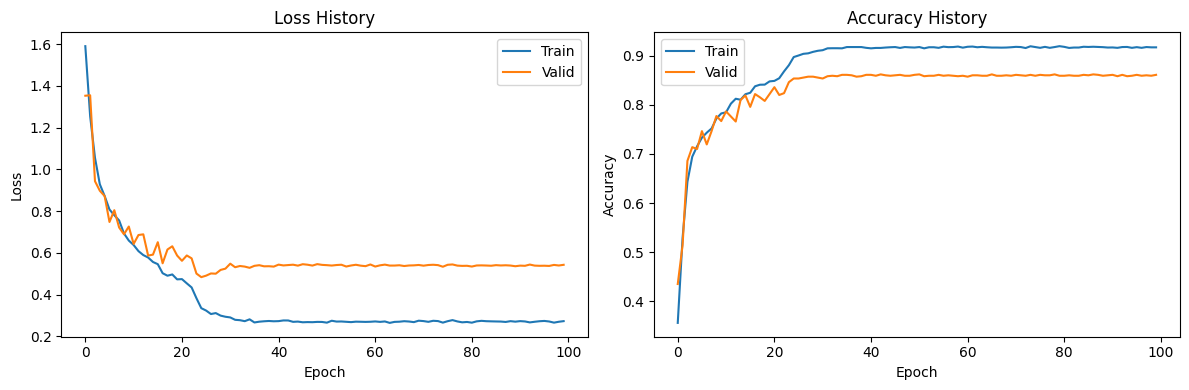

<ipython-input-23-14062a546d7a>:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))



Test Accuracy: 0.8510


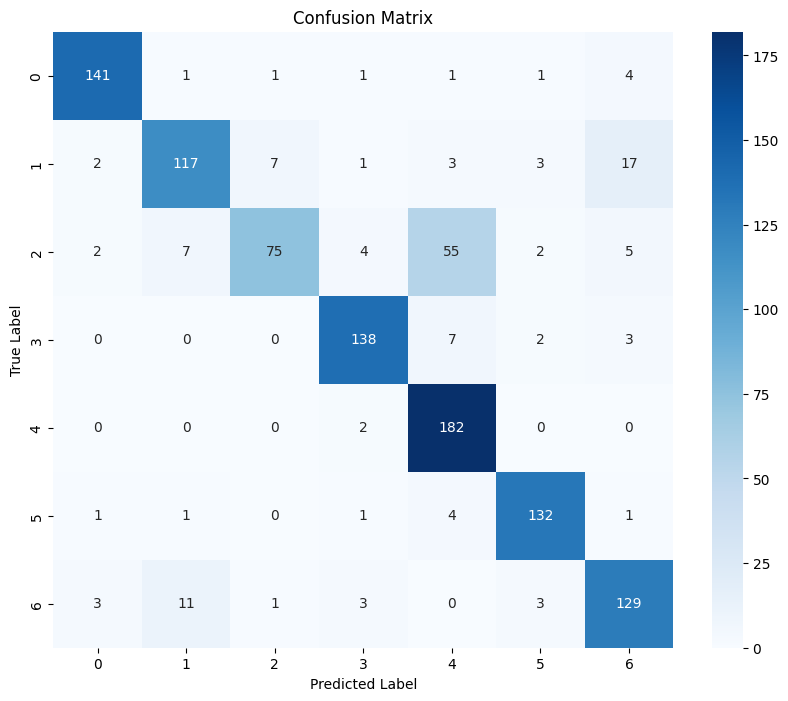


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       150
           1       0.85      0.78      0.82       150
           2       0.89      0.50      0.64       150
           3       0.92      0.92      0.92       150
           4       0.72      0.99      0.83       184
           5       0.92      0.94      0.93       140
           6       0.81      0.86      0.83       150

    accuracy                           0.85      1074
   macro avg       0.87      0.85      0.85      1074
weighted avg       0.86      0.85      0.84      1074



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

class MFCC_LSTM(nn.Module):
    def __init__(self, input_size=13, hidden_size=128, num_layers=2, num_classes=8, dropout=0.3):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,      # 13 MFCC features
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )

        self.fc1 = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size),
            nn.Dropout(dropout)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(hidden_size, num_classes)
        )
    def forward(self, x):
        # x shape: (batch_size, 13, sequence_length)
        # Transpose to (batch_size, sequence_length, 13) for LSTM
        x = x.transpose(1, 2)

        # LSTM forward pass
        lstm_out, _ = self.lstm(x)

        # # Take the output from the last time step
        last_output = lstm_out[:, -1, :]

        # # Fully connected layer
        # out = self.fc(last_output)
        # return out

        # Fully connected layers
        out = self.fc1(last_output)
        out = self.fc2(out)
        return out

# Training function with progress bar
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc='Training')
    for batch_x, batch_y in progress_bar:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{total_loss/len(progress_bar):.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })

    return total_loss / len(train_loader), correct / total

# Validation function
def validate(model, valid_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_x, batch_y in valid_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    return total_loss / len(valid_loader), correct / total

# Prepare your data
def prepare_data_loaders(X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=32):
    # Convert to tensors
    train_data = torch.FloatTensor(X_train)
    train_labels = torch.LongTensor(y_train)
    valid_data = torch.FloatTensor(X_valid)
    valid_labels = torch.LongTensor(y_valid)
    test_data = torch.FloatTensor(X_test)
    test_labels = torch.LongTensor(y_test)

    # Create datasets
    train_dataset = TensorDataset(train_data, train_labels)
    valid_dataset = TensorDataset(valid_data, valid_labels)
    test_dataset = TensorDataset(test_data, test_labels)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, valid_loader, test_loader

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Main training loop
def main():
    # Hyperparameters
    HIDDEN_SIZE = 128
    NUM_LAYERS = 2
    DROPOUT = 0.3
    BATCH_SIZE = 32
    NUM_EPOCHS = 100
    LEARNING_RATE = 0.001

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Remap labels to be consecutive
    label_map = {0:0, 2:1, 3:2, 4:3, 6:4, 8:5, 9:6}
    y_train_mapped = np.array([label_map[y] for y in y_train])
    y_valid_mapped = np.array([label_map[y] for y in y_valid])
    y_test_mapped = np.array([label_map[y] for y in y_test])

    # Prepare data loaders
    train_loader, valid_loader, test_loader = prepare_data_loaders(
        X_train, y_train_mapped,
        X_valid, y_valid_mapped,
        X_test, y_test_mapped,
        BATCH_SIZE
    )

    # Initialize model
    model = MFCC_LSTM(
        input_size=13,
        hidden_size=HIDDEN_SIZE,
        num_layers=NUM_LAYERS,
        num_classes=len(label_map),
        dropout=DROPOUT
    ).to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

    # Training history
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []
    best_valid_acc = 0

    # Training loop
    for epoch in range(NUM_EPOCHS):
        print(f'\nEpoch {epoch+1}/{NUM_EPOCHS}')

        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

        # Validate
        valid_loss, valid_acc = validate(model, valid_loader, criterion, device)

        # Store history
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accs.append(train_acc)
        valid_accs.append(valid_acc)

        # Print epoch results
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}')

        # Learning rate scheduling
        scheduler.step(valid_loss)

        # Save best model
        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            torch.save(model.state_dict(), 'best_model.pth')

    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(valid_losses, label='Valid')
    plt.title('Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train')
    plt.plot(valid_accs, label='Valid')
    plt.title('Accuracy History')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Load best model and evaluate on test set
    model.load_state_dict(torch.load('best_model.pth'))
    test_loss, test_acc = validate(model, test_loader, criterion, device)
    print(f'\nTest Accuracy: {test_acc:.4f}')

    # Get predictions for confusion matrix
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)
            outputs = model(batch_x)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.numpy())

    # Plot confusion matrix
    plot_confusion_matrix(all_labels, all_preds, classes=range(len(label_map)))

    # Print classification report
    print('\nClassification Report:')
    print(classification_report(all_labels, all_preds))

if __name__ == "__main__":
    main()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

class MFCC_LSTM(nn.Module):
    def __init__(self, input_size=13, hidden_size=128, num_layers=2, num_classes=8, dropout=0.3):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,      # 13 MFCC features
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )

        self.fc1 = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size),
            nn.Dropout(dropout)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(hidden_size, num_classes)
        )
    def forward(self, x):
        # x shape: (batch_size, 13, sequence_length)
        # Transpose to (batch_size, sequence_length, 13) for LSTM
        x = x.transpose(1, 2)

        # LSTM forward pass
        lstm_out, _ = self.lstm(x)

        # # Take the output from the last time step
        last_output = lstm_out[:, -1, :]

        # # Fully connected layer
        # out = self.fc(last_output)
        # return out

        # Fully connected layers
        out = self.fc1(last_output)
        out = self.fc2(out)
        return out


In [ ]:
import torch
import librosa
import numpy as np
from torch import nn

def extract_mfcc_features(audio_path):
    """
    Extract MFCC features from an audio file.
    Returns features of shape (13, 200) through padding or truncating.
    """
    # Load audio file
    y, sr = librosa.load(audio_path)

    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    # Pad or truncate to 200 time steps
    if mfcc.shape[1] < 200:
        # Pad with zeros if shorter
        pad_width = ((0, 0), (0, 200 - mfcc.shape[1]))
        mfcc = np.pad(mfcc, pad_width, mode='constant')
    else:
        # Truncate if longer
        mfcc = mfcc[:, :200]

    return mfcc

def detect_gunshot(audio_path, model_path, device='cpu'):
    """
    Detect gunshot in audio file using the trained model.
    Returns predicted class and probability.
    """
    # Initialize model
    model = MFCC_LSTM(input_size=13, hidden_size=128, num_layers=2, num_classes=7)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    # Extract features
    features = extract_mfcc_features(audio_path)

    # Convert to tensor and add batch dimension
    features_tensor = torch.FloatTensor(features).unsqueeze(0).to(device)

    # Get prediction
    with torch.no_grad():
        outputs = model(features_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        predicted_class = torch.argmax(outputs, dim=1).item()
        confidence = probabilities[0][predicted_class].item()

    # Map back to original labels (assuming the same mapping as in training)
    label_map = {0:0, 1:2, 2:3, 3:4, 4:6, 5:8, 6:9}
    original_label = label_map[predicted_class]

    return original_label, confidence

def process_audio_file(audio_path, model_path):
    """
    Process an audio file and print the detection results.
    """
    # Detect gunshot
    predicted_class, confidence = detect_gunshot(audio_path, model_path)

    # Print results
    print(f"Audio file: {audio_path}")
    print(f"Predicted class: {predicted_class}")
    print(f"Confidence: {confidence:.2%}")


In [ ]:

audio_file = '/content/samples/Dog Barking Sound Effect - Copyright free [TubeRipper.com].wav'
model_path = "/content/d3_best_model.pth"
process_audio_file(audio_file, model_path)

<ipython-input-57-841ecb4165a8>:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Audio file: /content/samples/Dog Barking Sound Effect - Copyright free [TubeRipper.com].wav
Predicted class: 6
Confidence: 96.46%


In [ ]:

audio_file ='/content/samples/Gunshot Sound Effect Single Shot [TubeRipper.com].wav'
model_path = "/content/d3_best_model.pth"
process_audio_file(audio_file, model_path)

Audio file: /content/samples/Gunshot Sound Effect Single Shot [TubeRipper.com].wav
Predicted class: 6
Confidence: 74.94%


<ipython-input-57-841ecb4165a8>:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


In [ ]:

audio_file = '/content/samples/sample.wav'
model_path = "/content/d3_best_model.pth"
process_audio_file(audio_file, model_path)

<ipython-input-57-841ecb4165a8>:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Audio file: /content/samples/sample.wav
Predicted class: 9
Confidence: 99.90%
